# Digit recognizer

In [1]:
### Importing libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from time import time
tf.logging.set_verbosity(tf.logging.INFO) # DEBUG,WARN,INFO,FATAL,ERROR

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [2]:
### Importing MNIST dataset
train=pd.read_csv("train.csv")
train=train.astype(float)
test=pd.read_csv("test.csv")
test=test.astype(float)

In [29]:
train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0
mean,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.2,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,2.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.3,4.6,3.3,1.8,1.9,0.4,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.0,254.0,253.0,253.0,254.0,62.0,0.0,0.0,0.0,0.0


In [84]:
### Splitting the training data
evl=train.iloc[:5000,:]
evl2=train.iloc[37000:,:]

### Splitting labels and features
evl_l=evl["label"].astype(int)
evl_f=evl.iloc[:,1:]

evl2_l=evl2["label"].astype(int)
evl2_f=evl2.iloc[:,1:]

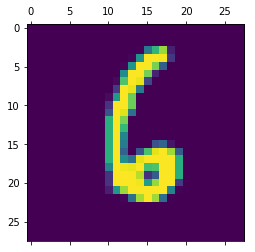

In [4]:
### Showing random example
random=np.random.randint(len(evl_f)-1)
_, ax = plt.subplots()
ax.matshow(evl_f.iloc[random,:].values.reshape(28, 28))
ax.grid(False)

### Convolutional neural network

In [5]:
def create_training_input_fn(features2,labels2,batch_size,epochs=None):
    def _input_fn():
        idx=np.random.permutation(features2.index.values)
        features=features2.reindex(idx)
        features={"pixels":features}
        labels=np.array(labels2[idx])
        ds=tf.data.Dataset.from_tensor_slices((features,labels))
        ds=ds.batch(batch_size).repeat(epochs)
        ds=ds.shuffle(40000)
        
        feature_batch,label_batch=ds.make_one_shot_iterator().get_next()
        return feature_batch,label_batch
    return _input_fn

In [6]:
def create_predict_input_fn(features2,labels2,batch_size):
    def _input_fn():
        features={"pixels":features2}
        labels=np.array(labels2)
        
        ds=tf.data.Dataset.from_tensor_slices((features,labels))
        ds=ds.batch(batch_size)
        
        feature_batch,label_batch=ds.make_one_shot_iterator().get_next()
        return feature_batch,label_batch
    return _input_fn

In [7]:
feature_column=[tf.feature_column.numeric_column(key="pixels",shape=[784])]

In [10]:
def my_model(features,labels,mode):
    input_layer= tf.reshape(features["pixels"], [-1, 28, 28, 1])
    conv1=tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=(5,5),padding="same",activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    conv2 = tf.layers.conv2d(inputs=pool1,filters=64,kernel_size=[5, 5],padding="same",activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    logits = tf.layers.dense(inputs=dropout, units=10)
    predicted_classes = tf.argmax(logits, 1)  
    
    predictions = {
            'class_ids': predicted_classes[:, tf.newaxis],
            'probabilities': tf.nn.softmax(logits, name="softmax_tensor"),
            'logits': logits
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss,global_step=tf.train.get_global_step())
        logging_hook=tf.train.LoggingTensorHook(tensors={"classes":predicted_classes},every_n_iter=1000)
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op,training_hooks=[logging_hook]) 
    
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["class_ids"])
    }   
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [83]:
def train_model(train_f,train_l,evl_f,evl_l,batch_size,steps,parts):
    config=tf.estimator.RunConfig(save_summary_steps=100000,keep_checkpoint_max=1)
    
    clf=tf.estimator.Estimator(model_fn=my_model,model_dir="C:\Python27\Digit_recognizer\Log2",config=config)
    
    for p in range(parts):
        start=p*len(train_f)/parts
        end=(p+1)*len(train_f)/parts
        print("Training on part %i of %i parts" %(p+1,parts))
        train_f_p=train_f.iloc[int(start):int(end),:]
        train_l_p=train_l.iloc[int(start):int(end)]
    
        train_input_fn=create_training_input_fn(features2=train_f_p,labels2=train_l_p,batch_size=batch_size)
        clf.train(input_fn=train_input_fn,steps=steps)
    
        evl_input_fn=create_predict_input_fn(features2=evl_f,labels2=evl_l,batch_size=1)
        print("Evaluation after training on data till %i" %(end))
        clf.evaluate(input_fn=evl_input_fn)

    return clf

In [85]:
clf2=train_model(evl_f,evl_l,evl2_f,evl2_l,5,3000,4)

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Python27\\Digit_recognizer\\Log2', '_tf_random_seed': None, '_save_summary_steps': 100000, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000014F912B8908>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Training on part 1 of 4 parts
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into C:\Python27\Digit_recognizer\Log2\mode

INFO:tensorflow:loss = 0.031095881015062332, step = 5301 (9.713 sec)
INFO:tensorflow:global_step/sec: 11.337
INFO:tensorflow:loss = 0.0012397861573845148, step = 5401 (8.486 sec)
INFO:tensorflow:global_step/sec: 11.5794
INFO:tensorflow:loss = 0.0014158820267766714, step = 5501 (8.636 sec)
INFO:tensorflow:global_step/sec: 11.2749
INFO:tensorflow:loss = 1.4379074855241925e-05, step = 5601 (8.869 sec)
INFO:tensorflow:global_step/sec: 11.7297
INFO:tensorflow:loss = 0.013083669357001781, step = 5701 (8.541 sec)
INFO:tensorflow:global_step/sec: 11.6844
INFO:tensorflow:loss = 0.0015347771113738418, step = 5801 (8.543 sec)
INFO:tensorflow:global_step/sec: 11.4422
INFO:tensorflow:loss = 0.0004143808037042618, step = 5901 (8.740 sec)
INFO:tensorflow:Saving checkpoints for 6000 into C:\Python27\Digit_recognizer\Log2\model.ckpt.
INFO:tensorflow:Loss for final step: 7.031839777482674e-05.
Evaluation after training on data till 2500
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling mode

INFO:tensorflow:loss = 0.00043812417425215244, step = 10501 (11.834 sec)
INFO:tensorflow:global_step/sec: 5.31653
INFO:tensorflow:loss = 0.003654558677226305, step = 10601 (18.809 sec)
INFO:tensorflow:global_step/sec: 8.53071
INFO:tensorflow:loss = 0.0007090111030265689, step = 10701 (11.722 sec)
INFO:tensorflow:global_step/sec: 8.09352
INFO:tensorflow:loss = 3.219191785319708e-05, step = 10801 (12.356 sec)
INFO:tensorflow:global_step/sec: 9.09346
INFO:tensorflow:loss = 0.00019864369824063033, step = 10901 (10.997 sec)
INFO:tensorflow:global_step/sec: 7.93066
INFO:tensorflow:loss = 0.0006858751294203103, step = 11001 (12.629 sec)
INFO:tensorflow:classes = [8 1 7 4 0] (121.391 sec)
INFO:tensorflow:global_step/sec: 8.58828
INFO:tensorflow:loss = 0.0893000140786171, step = 11101 (11.626 sec)
INFO:tensorflow:global_step/sec: 8.19696
INFO:tensorflow:loss = 0.048006996512413025, step = 11201 (12.481 sec)
INFO:tensorflow:global_step/sec: 8.10221
INFO:tensorflow:loss = 0.001018830924294889, st

In [56]:
predict_input_fn=create_predict_input_fn(test.iloc[:,:],test.iloc[:],1)
pred=clf.predict(input_fn=predict_input_fn)
outcome=[]
for i in pred:
    outcome.append(i["class_ids"][0])
outcome=np.array(outcome)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Python27\Digit_recognizer\Log\model.ckpt-5001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [43]:
sample=pd.read_csv("sample_submission.csv")
sample["Label"]=outcome
sample.to_csv("Submission.csv",index=False)

In [31]:
clf2.get_variable_names()

['conv2d/bias',
 'conv2d/kernel',
 'conv2d_1/bias',
 'conv2d_1/kernel',
 'dense/bias',
 'dense/kernel',
 'dense_1/bias',
 'dense_1/kernel',
 'global_step']

In [37]:
a=clf2.get_variable_value("dense/kernel")

In [36]:
from sys import getsizeof

In [45]:
getsizeof(a[0][0])

32

In [46]:
a[0][0]

-0.000580821071791104

In [57]:
a.nbytes

25690112

In [59]:
a.shape

(3136, 1024)

In [60]:
type(a[0][0])

numpy.float64

In [61]:
type(a[1])

numpy.ndarray

In [63]:
type(a[1][1])

numpy.float64

In [76]:
np.array(train).nbytes/42000


6280.0

In [66]:
evl.iloc[0].shape

(785,)

In [67]:
785*64

50240

In [68]:
evl.iloc[0]

label      4.0
pixel0     0.0
pixel1     0.0
pixel2     0.0
pixel3     0.0
            ..
pixel779   0.0
pixel780   0.0
pixel781   0.0
pixel782   0.0
pixel783   0.0
Name: 29600, Length: 785, dtype: float64